In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from EDA.plot_functions import plot_target_by_feature,plot_kde_by_feature


In [27]:
application_train = pd.read_csv('../data/application_train.csv')
application_train.head()
application_train.shape

(307511, 122)

In [3]:
application_null = (
    application_train.isnull().sum()
        .to_frame(name='sum_of_nulls')
        .assign(percent_null=lambda d: d['sum_of_nulls'] * 100 / len(application_train))
        .reset_index(names='column')
        .sort_values('percent_null', ascending=False)
)

application_null

,column,sum_of_nulls,percent_null
76,COMMONAREA_MEDI,214865,69.872297
48,COMMONAREA_AVG,214865,69.872297
62,COMMONAREA_MODE,214865,69.872297
70,NONLIVINGAPARTMENTS_MODE,213514,69.432963
56,NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...,...
15,NAME_HOUSING_TYPE,0,0.000000
14,NAME_FAMILY_STATUS,0,0.000000
13,NAME_EDUCATION_TYPE,0,0.000000
12,NAME_INCOME_TYPE,0,0.000000


Around 50 of the missing values are about information about building where the client lives.
Does housing data missing mean non-standard housing (higher risk profiles)?? Better to include them as a flag - Housing data exists or not.

/var/folders/x3/lt96tpqn5b9916m5ndt4xdfr0000gn/T/ipykernel_4201/4152544229.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index)


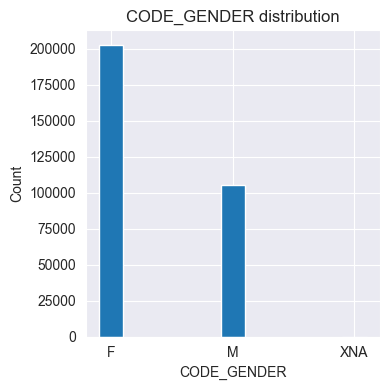

In [4]:
counts = application_train['CODE_GENDER'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(4, 4))
bars = ax.bar(counts.index, counts.values, width=0.2)
ax.set_xlabel("CODE_GENDER")
ax.set_ylabel("Count")
ax.set_title("CODE_GENDER distribution")
ax.set_xticklabels(counts.index)

plt.tight_layout()
plt.show()

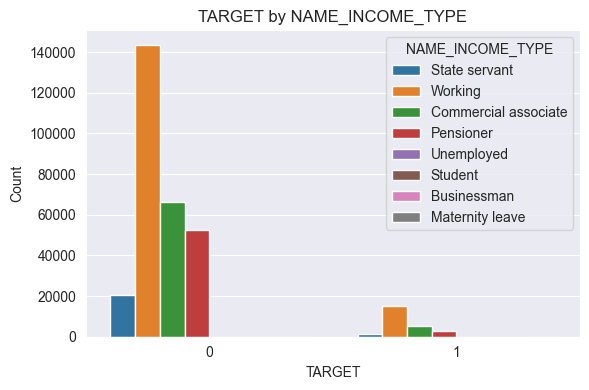

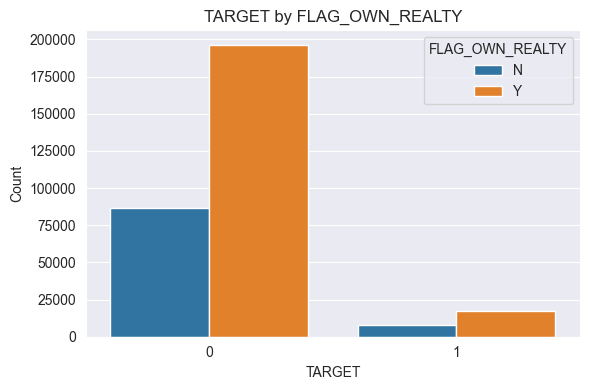

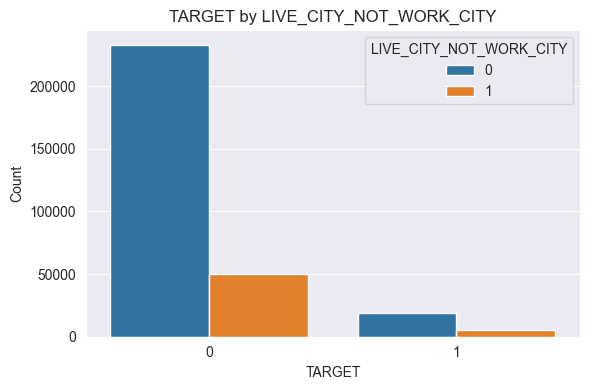

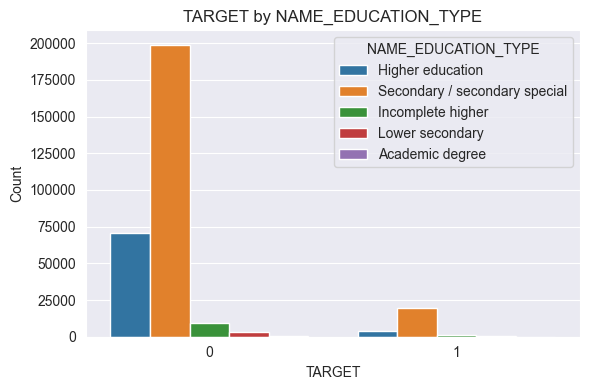

In [5]:

plot_target_by_feature(df=application_train, contract_col='NAME_INCOME_TYPE')
plot_target_by_feature(df=application_train, contract_col='FLAG_OWN_REALTY')
plot_target_by_feature(df=application_train, contract_col='LIVE_CITY_NOT_WORK_CITY')
plot_target_by_feature(df=application_train, contract_col='NAME_EDUCATION_TYPE')

- Academic degree holders are not much in the dataset.
- I think it is UNFAIR to use gender in the training data - will drop
- Rest of the features do not say much as of now

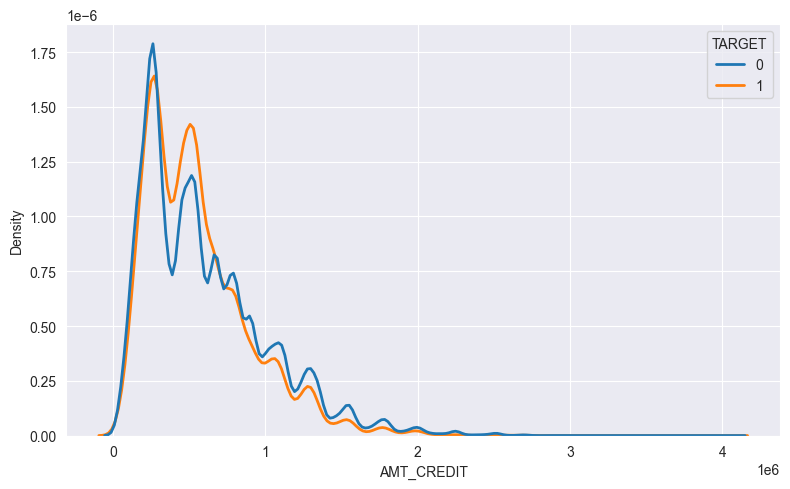

In [6]:
plot_kde_by_feature(df = application_train,feature="AMT_CREDIT")

- Both classes have similar right‑skewed distributions, with most credit amounts clustered around roughly 200k–600k and a long tail extending above 1M.
- Defaulted cases are not dramatically different in credit amount from non‑default cases.

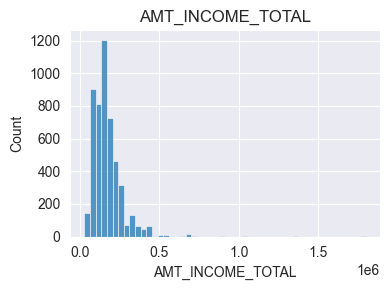

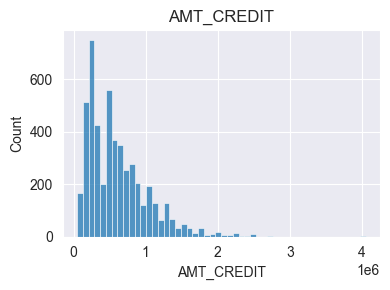

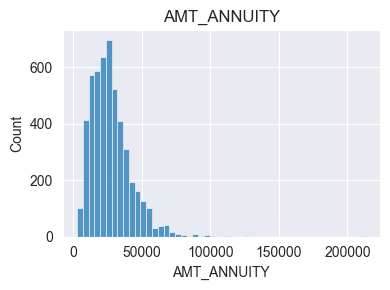

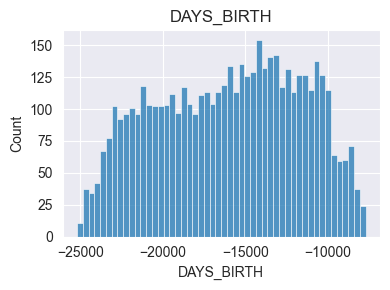

In [28]:
for col in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "DAYS_BIRTH"]:
    if col in application_train.columns:
        plt.figure(figsize=(4,3))
        sns.histplot(application_train[col].dropna().sample(min(5000, application_train[col].dropna().shape[0])), bins=50)
        plt.title(col)
        plt.tight_layout()
        plt.show()

The amount features seem to be rightly skewed - as expected. XGboost can take care of skewed data. Probably can leave it as it is.

In [8]:
missing_stats = (
        application_train.isnull().mean()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={'index': 'column', 0: 'missing_ratio'})
    )
high_missing_cols = missing_stats.query("missing_ratio >= 0.3")['column'].tolist()

In [9]:
missing_flags = application_train.isnull().astype(int)
missing_corr = missing_flags.corr()
mask = np.triu(np.ones_like(missing_corr, dtype=bool))
missing_corr_masked = missing_corr.mask(mask)
missing_corr_filtered = missing_corr_masked.stack().dropna()
print(missing_corr_filtered)

AMT_GOODS_PRICE             AMT_ANNUITY                  -0.000188
NAME_TYPE_SUITE             AMT_ANNUITY                  -0.000406
                            AMT_GOODS_PRICE               0.463098
OWN_CAR_AGE                 AMT_ANNUITY                   0.001188
                            AMT_GOODS_PRICE               0.021595
                                                            ...   
AMT_REQ_CREDIT_BUREAU_YEAR  AMT_REQ_CREDIT_BUREAU_HOUR    1.000000
                            AMT_REQ_CREDIT_BUREAU_DAY     1.000000
                            AMT_REQ_CREDIT_BUREAU_WEEK    1.000000
                            AMT_REQ_CREDIT_BUREAU_MON     1.000000
                            AMT_REQ_CREDIT_BUREAU_QRT     1.000000
Length: 2211, dtype: float64


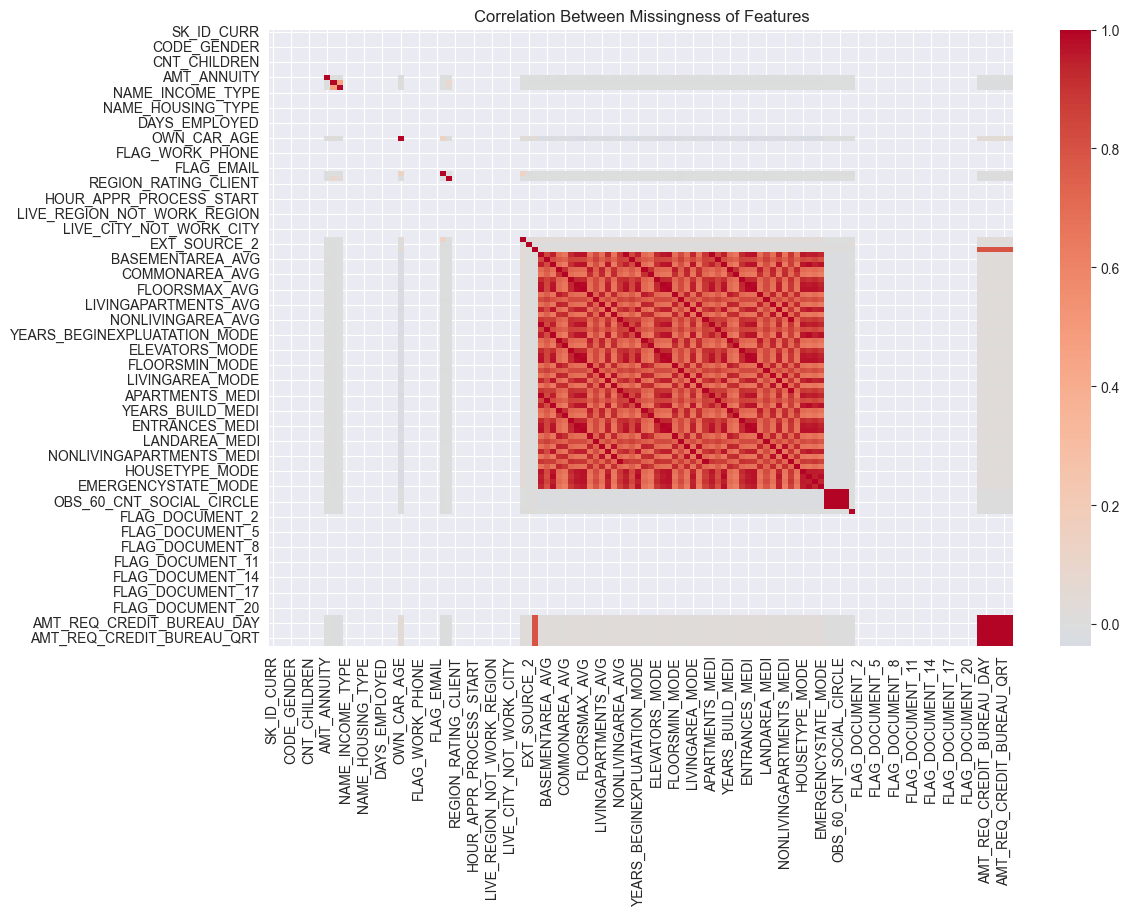

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(missing_corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Between Missingness of Features')
plt.show()

There are a lot of columns which are misisng together.It looks like these columns belong to the same category or represent similar types of features (e.g., real estate related variables like BASEMENTAREA_AVG, COMMONAREA_AVG, FLOORSMAX_AVG, etc.).
When one of these columns is missing, the others are also likely missing — meaning missingness is clustered and probably related to the same underlying reason (like not having a basement or a specific apartment type).
Correlation between AMT_REQ_CREDIT_BUREAU_DAY and AMT_REQ_CREDIT_BUREAU_QRT columns suggests missingness there is strongly related — possibly because those fields come from the same external source

For features with nontrivial or correlated missingness,I would go ahead with the binary indicators so the model can learn from the pattern itself.
Indicators are particularly useful for tree-based models and additive models designed to use them
These models can capture risk signals from process gaps like missing documents.

In [11]:
df_imputed = application_train.copy(deep=True)
for col in high_missing_cols:
    df_imputed[f'FLAG_MISS_{col}'] = df_imputed[col].isnull().astype(int)

For the rest of the missing values, Let's have a look at what they represent:

In [12]:
low_missing_cols = missing_stats.query("missing_ratio < 0.3 & missing_ratio  > 0")['column'].tolist()
print(f"Columns to impute: {len(low_missing_cols)}")
print(low_missing_cols)

Columns to impute: 17
['EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']


Simple mean/median imputation isn't appropriate for these variables given their business context and meaning after referring to the descriptions file.

For `AMT_REQ_CREDIT_BUREAU_` variables, missing values likely indicate no enquiries occurred:
For `OBS_30_CNT_SOCIAL_CIRCLE`, `DEF_30_CNT_SOCIAL_CIRCLE`, etc., missing likely means no observations; Hence I will impute them with 0 - Missing = no enquiries = lower risk signal

In [13]:
credit_bureau_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                     'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                     'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

social_circle_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                     'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
cols_to_impute_zero = credit_bureau_cols + social_circle_cols
for col in cols_to_impute_zero:
    df_imputed.fillna({col: 0}, inplace=True)

I would use simple imputation strategies (mode/median) for `CNT_FAM_MEMBERS`, `NAME_TYPE_SUITE`, `DAYS_LAST_PHONE_CHANGE`
If `NAME_TYPE_SUITE` is NaN, I think it is safe to assume the person was unaccompanied.

In [14]:
df_imputed.fillna({'CNT_FAM_MEMBERS':df_imputed['CNT_FAM_MEMBERS'].mode()[0]}, inplace=True)
df_imputed.fillna({'NAME_TYPE_SUITE':'Unaccompanied'}, inplace=True)
df_imputed.fillna({'DAYS_LAST_PHONE_CHANGE':df_imputed['DAYS_LAST_PHONE_CHANGE'].median()}, inplace=True)

In [15]:
ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
numerical_cols = application_train.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = application_train[numerical_cols].corr()

ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
ext_correlations = correlation_matrix[ext_source_cols].copy()


In [16]:
def find_top_correlations(df, target_cols, min_correlation=0.1, exclude_self=True):
    """
    Find features most correlated with target columns
    """
    correlation_results = {}

    for target_col in target_cols:
        if target_col not in df.columns:
            continue

        correls = df.corr()[target_col].abs().sort_values(ascending=False)

        if exclude_self:
            correls = correls.drop(target_col, errors='ignore')

        high_correls = correls[correls >= min_correlation]

        correlation_results[target_col] = high_correls

        print(f"\n=== {target_col} - Top Correlations (>{min_correlation}) ===")
        for feature, corr_value in high_correls.head(10).items():
            print(f"{feature}: {corr_value:.3f}")

    return correlation_results

numeric_cols = application_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_data = application_train[numeric_cols]

print(f"Total columns: {len(application_train.columns)}")
print(f"Numeric columns: {len(numeric_cols)}")
top_correlations = find_top_correlations(
    numeric_data,
    ext_source_cols,
    min_correlation=0.05
)


Total columns: 122
Numeric columns: 106

=== EXT_SOURCE_1 - Top Correlations (>0.05) ===
DAYS_BIRTH: 0.601
FLAG_EMP_PHONE: 0.294
DAYS_EMPLOYED: 0.290
EXT_SOURCE_2: 0.214
FLAG_DOCUMENT_6: 0.191
EXT_SOURCE_3: 0.187
REG_CITY_NOT_WORK_CITY: 0.186
DAYS_REGISTRATION: 0.181
AMT_GOODS_PRICE: 0.176
AMT_CREDIT: 0.168

=== EXT_SOURCE_2 - Top Correlations (>0.05) ===
REGION_RATING_CLIENT: 0.293
REGION_RATING_CLIENT_W_CITY: 0.288
EXT_SOURCE_1: 0.214
REGION_POPULATION_RELATIVE: 0.199
DAYS_LAST_PHONE_CHANGE: 0.196
TARGET: 0.160
HOUR_APPR_PROCESS_START: 0.157
AMT_GOODS_PRICE: 0.139
FLOORSMAX_AVG: 0.136
FLOORSMAX_MEDI: 0.135

=== EXT_SOURCE_3 - Top Correlations (>0.05) ===
DAYS_BIRTH: 0.205
EXT_SOURCE_1: 0.187
TARGET: 0.179
DAYS_ID_PUBLISH: 0.132
FLAG_EMP_PHONE: 0.115
DAYS_EMPLOYED: 0.113
EXT_SOURCE_2: 0.109
DAYS_REGISTRATION: 0.108
REG_CITY_NOT_WORK_CITY: 0.080
REG_CITY_NOT_LIVE_CITY: 0.078


 I would use top 3-4 correlated features for each EXT_SOURCE and run a KNN Imputer on External Sources

In [17]:
ages = (-application_train['DAYS_BIRTH'] / 365).dropna()
print('Min age (years):', ages.min())
print('Max age (years):', ages.max())
print('Proportion <18:', (ages < 18).mean())

Min age (years): 20.517808219178082
Max age (years): 69.12054794520547
Proportion <18: 0.0


Age seems to be in the right range. Data seems to be clean except for missing values. I would treat columns with ≥30 % missingness as potentially informative.
Creates binary missingness indicators to keep them as informative in the data

Let's have a detailed look at any age inconsistency given employment duration

In [18]:
def validate_age_employment_consistency(df:pd.DataFrame)->dict:

    df['age_years'] = abs(df['DAYS_BIRTH']) / 365.25
    df['employment_years'] = abs(df['DAYS_EMPLOYED']) / 365.25

    # Rule 1: Employment length cannot exceed working age
    # Assuming people start working at 16
    max_possible_employment = df['age_years'] - 16

    invalid_employment = df[df['employment_years'] > max_possible_employment]

    # Rule 2: Unrealistic employment scenarios
    # Very young people with extensive employment history
    young_overemployed = df[
        (df['age_years'] < 25) &
        (df['employment_years'] > 10)
    ]

    # Rule 3: Senior citizens with recent employment start
    # People over 65 who supposedly just started working
    senior_new_employment = df[
        (df['age_years'] > 65) &
        (df['employment_years'] < 1)
    ]

    consistency_report = {
        'total_records': len(df),
        'invalid_employment_length': len(invalid_employment),
        'young_overemployed': len(young_overemployed),
        'senior_new_employment': len(senior_new_employment),
        'overall_consistency_rate': 1 - ((len(invalid_employment)-len(young_overemployed)-len(senior_new_employment)) / len(df))
    }

    return consistency_report
validate_age_employment_consistency(df=application_train)

{'total_records': 307511,
 'invalid_employment_length': 55374,
 'young_overemployed': 34,
 'senior_new_employment': 34,
 'overall_consistency_rate': 0.8201495231064905}

There seems to be heavy inconsistency, 18% of the records have employed years higher than possible number of years. Let's have a look at it in detail.

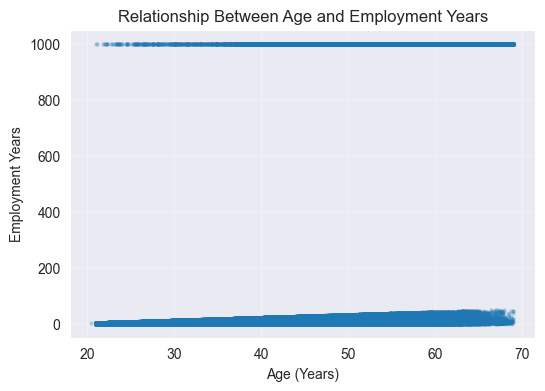

In [19]:
df = application_train.copy()
df['age_years'] = abs(df['DAYS_BIRTH']) / 365.25
df['employment_years'] = abs(df['DAYS_EMPLOYED']) / 365.25
plt.figure(figsize=(6, 4))
plt.scatter(df['age_years'], df['employment_years'], alpha=0.2, s=5)
plt.xlabel('Age (Years)')
plt.ylabel('Employment Years')
plt.title('Relationship Between Age and Employment Years')
plt.grid(True, alpha=0.3)
plt.show()

Clearly there seems to be an error in data collection or documentation in employment years. For a lot of records, the employment year is close to 1000 years which is absurd.

Let's check for some other inconsistencies, related to family and

In [20]:
def extra_consistency_checks(df):
    """
    Multiple consistency checks for credit risk data
    """
    issues = {}

    # 1. Family size consistency
    if 'CNT_FAM_MEMBERS' in df.columns:
        invalid_family_size = df[
            (df['CNT_FAM_MEMBERS'] < 1) |
            (df['CNT_FAM_MEMBERS'] > 20)
        ]
        issues['invalid_family_size'] = len(invalid_family_size)

    # 2. Registration vs Birth date logic
    if 'DAYS_REGISTRATION' in df.columns:
        df['registration_years'] = abs(df['DAYS_REGISTRATION']) / 365.25
        invalid_registration = df[df['registration_years'] > df['age_years']]
        issues['invalid_registration'] = len(invalid_registration)

    return issues
extra_consistency_checks(df=application_train)

{'invalid_family_size': 0, 'invalid_registration': 1}

There seems to be minor inconsistency issue with regards to days_registration. Probbaly can ignore it.

Let's now focus on some feature engineering

In [21]:
#Income and credit related features
df['debt_to_income'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['payment_to_income_ratio'] = (df['AMT_ANNUITY'] * 12) / df['AMT_INCOME_TOTAL']
df['residual_income'] = df['AMT_INCOME_TOTAL'] - (df['AMT_ANNUITY'] * 12)
df['credit_per_family_member'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']


In [22]:
# Age and employment related features
df['career_stage'] = pd.cut(df['age_years'],
                           bins=[0, 25, 35, 50, 65, 100],
                           labels=['Early', 'Establishing', 'Peak', 'Senior', 'Retirement'])

# Employment stability
df['employment_stability'] = df['employment_years'] / df['age_years']

# Years until retirement (assuming retirement at 65)
df['years_to_retirement'] = 65 - df['age_years']

In [23]:
#Family Indicators
df['children_ratio'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
df['income_per_family_member'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['large_family'] = (df['CNT_FAM_MEMBERS'] >= 5).astype(int)
#Single parent would be riskier
df['single_parent'] = ((df['CNT_CHILDREN'] > 0) &
                      (df['NAME_FAMILY_STATUS'] == 'Single / not married')).astype(int)
df['low_income_large_family'] = ((df['AMT_INCOME_TOTAL'] < df['AMT_INCOME_TOTAL'].quantile(0.25)) &
                                 (df['CNT_FAM_MEMBERS'] >= 4)).astype(int)

In [24]:
df['young_high_credit'] = ((df['age_years'] < 30) &
                          (df['debt_to_income'] > 5)).astype(int)

In [25]:
def validate_credit_data(df: pd.DataFrame) -> dict:
    """
    Basic data quality checks.
    """
    validation_report = {
        'negative_income_count': (df['AMT_INCOME_TOTAL'] < 0).sum(),
        'extreme_age_count': ((df['age_years'] < 18) | (df['age_years'] > 100)).sum(),
        'debt_ratio_outliers': (df['debt_to_income'] > 20).sum(),
        'missing_critical_fields': df[['AMT_INCOME_TOTAL', 'AMT_CREDIT']].isnull().sum().to_dict()
    }
    return validation_report
validate_credit_data(df)

{'negative_income_count': np.int64(0),
 'extreme_age_count': np.int64(0),
 'debt_ratio_outliers': np.int64(235),
 'missing_critical_fields': {'AMT_INCOME_TOTAL': 0, 'AMT_CREDIT': 0}}